In [1]:
# =========================================
# Projeto: Statistical Inference Project
# Etapa: Estimação por Máxima Verossimilhança (MLE)
# Autor: João Victor Barros
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from scipy import stats
from scipy.optimize import minimize
from scipy.special import betaln

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import savefig

FIG_DIR = "../figures/mle/" 
os.makedirs(FIG_DIR, exist_ok=True)

plt.style.use('default')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
file_path = "../data/ndt_tests_corrigido.csv"
try:
    df = pd.read_csv(file_path, parse_dates=[0])
except FileNotFoundError:
    print("Erro: O arquivo '.csv' não foi encontrado. Verifique o caminho.")

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02+00:00,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11+00:00,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43+00:00,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07+00:00,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21+00:00,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


In [3]:
df.columns

Index(['timestamp', 'download_throughput_bps', 'rtt_download_sec',
       'upload_throughput_bps', 'rtt_upload_sec', 'packet_loss_percent',
       'client', 'server'],
      dtype='object')

In [4]:
def neg_loglik_beta(params, data):
    """Log-verossimilhança negativa da distribuição Beta"""
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    ll = ((a-1)*np.log(data) + (b-1)*np.log(1-data)).sum() - len(data)*betaln(a,b)
    return -ll

Client 13

In [5]:
df_c1 = df[df['client'] == 'client13'].copy()


📈 rtt_download_sec: μ̂=0.011748, σ̂=0.005652
Figura salva: ../figures/mle/rtt_download_sec_ajuste_normal_client13.png


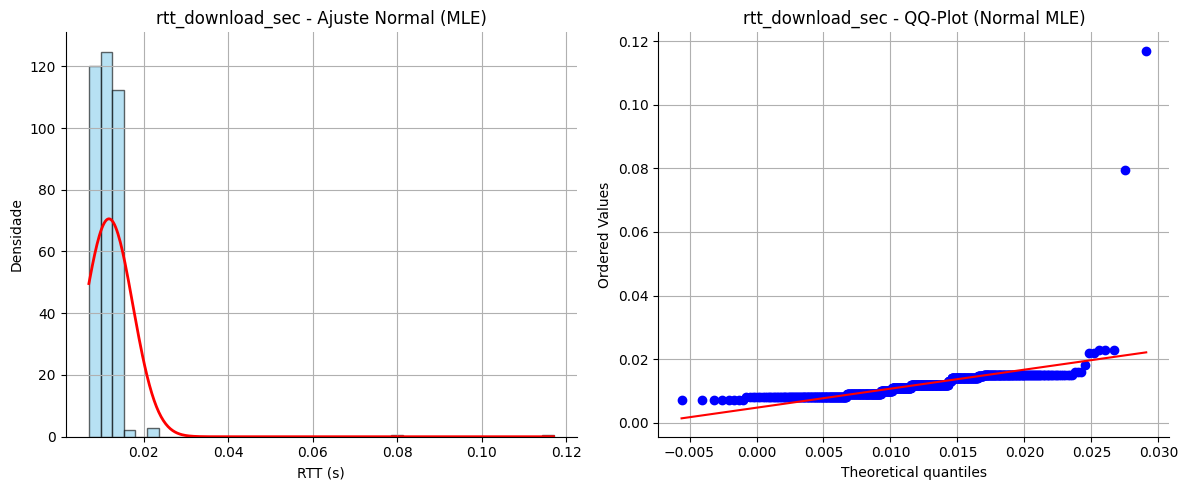


📈 rtt_upload_sec: μ̂=0.012986, σ̂=0.004991
Figura salva: ../figures/mle/rtt_upload_sec_ajuste_normal_client13.png


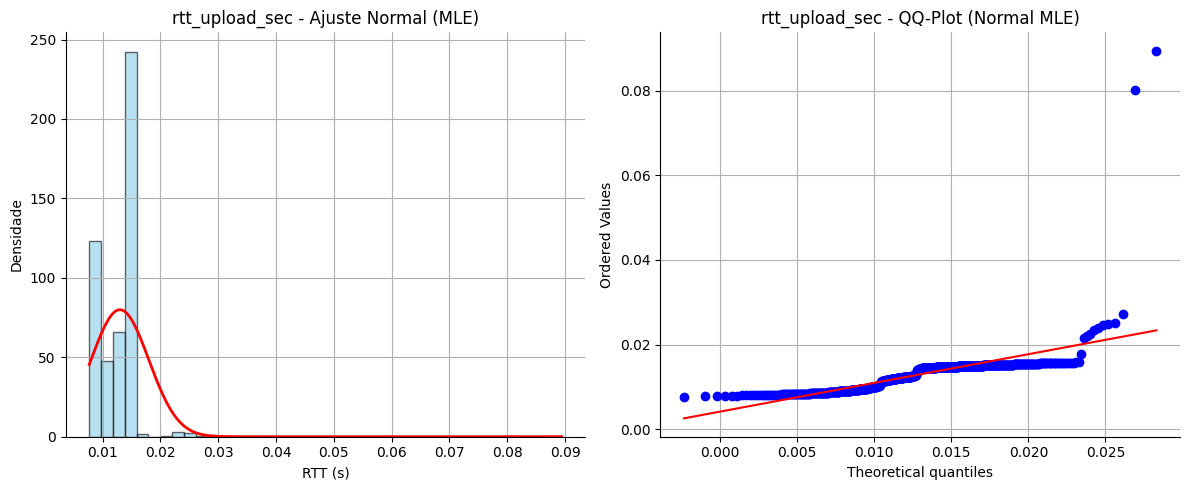

In [6]:
rtt_vars = ['rtt_download_sec', 'rtt_upload_sec']
mle_results = []

for var in rtt_vars:
    data = df_c1[var].values
    mu_mle = np.mean(df_c1[var])
    sigma_mle = np.sqrt(np.mean((df_c1[var] - mu_mle)**2))
    
    print(f"\n📈 {var}: μ̂={mu_mle:.6f}, σ̂={sigma_mle:.6f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(df_c1[var], bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    x = np.linspace(df_c1[var].min(), df_c1[var].max(), 400)
    axes[0].plot(x, stats.norm.pdf(x, mu_mle, sigma_mle), 'r-', lw=2)
    axes[0].set_title(f"{var} - Ajuste Normal (MLE)")
    axes[0].set_xlabel("RTT (s)")
    axes[0].set_ylabel("Densidade")

    stats.probplot(df_c1[var], dist="norm", sparams=(mu_mle, sigma_mle), plot=axes[1])
    axes[1].set_title(f"{var} - QQ-Plot (Normal MLE)")

    plt.tight_layout()
    filename_scatter = f"{var}_ajuste_normal_client13.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    mle_results.append((var, "Normal", f"μ̂={mu_mle:.4g}, σ̂={sigma_mle:.4g}", len(df_c1[var])))


⚙️ download_throughput_bps: k̂=348.781682, θ̂=1702879.463415


Figura salva: ../figures/mle/download_throughput_bps_ajuste_gamma_client13.png


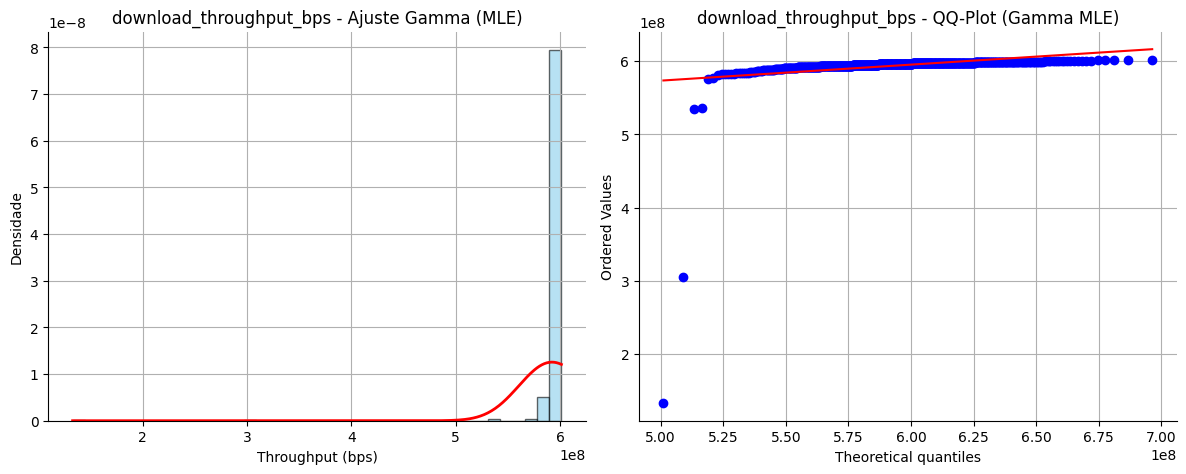


⚙️ upload_throughput_bps: k̂=173.134749, θ̂=1702515.217247
Figura salva: ../figures/mle/upload_throughput_bps_ajuste_gamma_client13.png


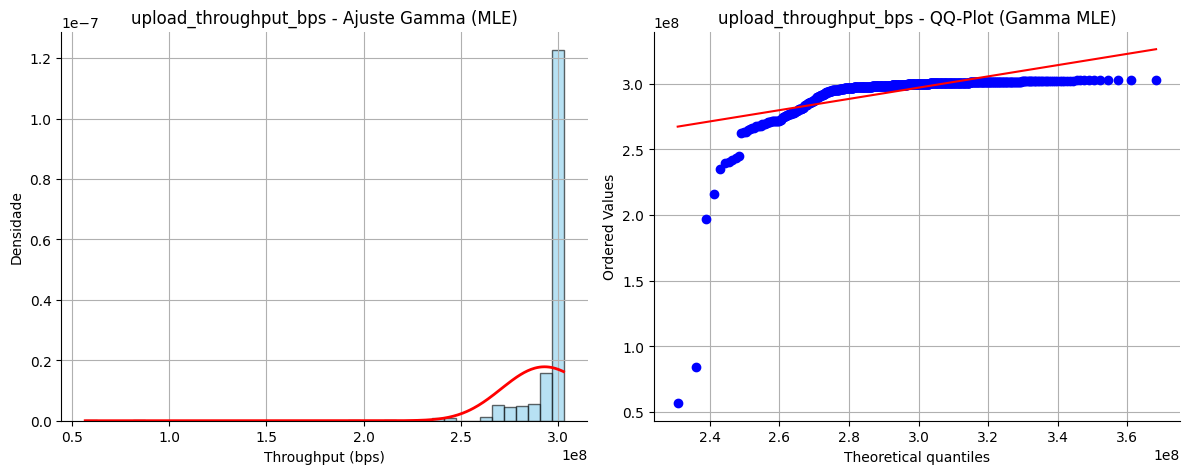

In [7]:
thr_vars = ['download_throughput_bps', 'upload_throughput_bps']

for var in thr_vars:
    data = df_c1[var]
    data = data[data > 0]
    
    shape, loc, scale = stats.gamma.fit(data, floc=0)
    print(f"\n⚙️ {var}: k̂={shape:.6f}, θ̂={scale:.6f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(data, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    x = np.linspace(data.min(), data.max(), 400)
    axes[0].plot(x, stats.gamma.pdf(x, a=shape, loc=0, scale=scale), 'r-', lw=2)
    axes[0].set_title(f"{var} - Ajuste Gamma (MLE)")
    axes[0].set_xlabel("Throughput (bps)")
    axes[0].set_ylabel("Densidade")

    stats.probplot(data, dist="gamma", sparams=(shape, 0, scale), plot=axes[1])
    axes[1].set_title(f"{var} - QQ-Plot (Gamma MLE)")

    plt.tight_layout()
    filename_scatter = f"{var}_ajuste_gamma_client13.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()
    
    mle_results.append((var, "Gamma", f"k̂={shape:.4g}, θ̂={scale:.4g}", len(data)))



📉 Packet Loss: α̂=8.769154, β̂=155.829402
Figura salva: ../figures/mle/packet_loss_ajuste_beta_client13.png


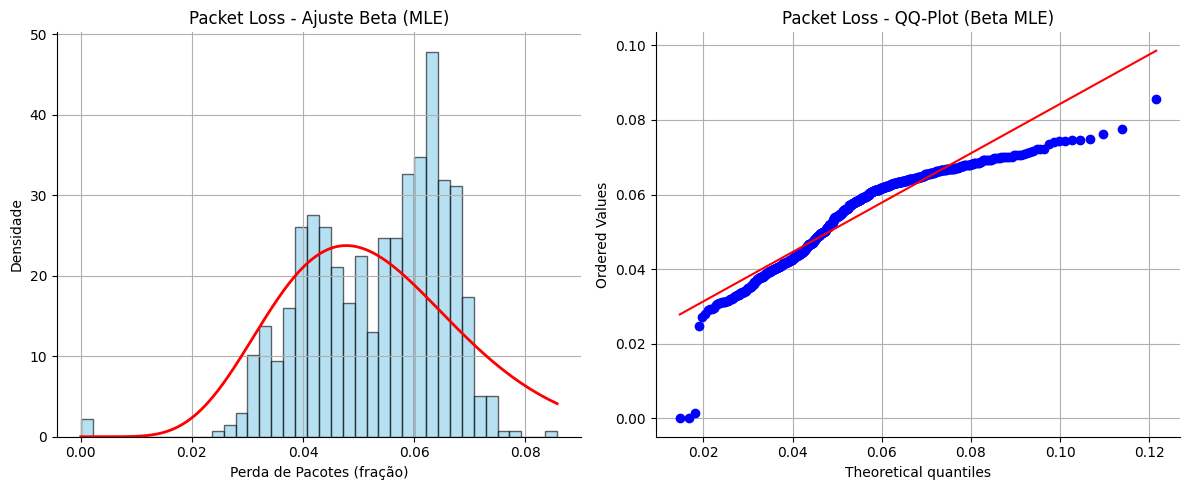

In [8]:
loss_percent = df_c1['packet_loss_percent']
loss_fraction = loss_percent / 100.0
loss_fraction_clipped = loss_fraction.clip(1e-6, 1 - 1e-6) 
a_mle, b_mle, loc, scale = stats.beta.fit(loss_fraction_clipped, floc=0, fscale=1)
print(f"\n📉 Packet Loss: α̂={a_mle:.6f}, β̂={b_mle:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(loss_fraction_clipped, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
x_min = loss_fraction_clipped.min()
x_max = loss_fraction_clipped.max()
x = np.linspace(x_min, x_max, 400)

axes[0].plot(x, stats.beta.pdf(x, a=a_mle, b=b_mle, loc=0, scale=1), 'r-', lw=2)
axes[0].set_title("Packet Loss - Ajuste Beta (MLE)")
axes[0].set_xlabel("Perda de Pacotes (fração)")
axes[0].set_ylabel("Densidade")

stats.probplot(loss_fraction_clipped, dist="beta", sparams=(a_mle, b_mle, 0, 1), plot=axes[1])
axes[1].set_title("Packet Loss - QQ-Plot (Beta MLE)")

plt.tight_layout()
filename_scatter = "packet_loss_ajuste_beta_client13.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()

mle_results.append(("packet_loss_percent", "Beta", f"α̂={a_mle:.4g}, β̂={b_mle:.4g}", len(loss_fraction)))

In [9]:
summary = pd.DataFrame(
    mle_results,
    columns=["Variável", "Distribuição", "Parâmetros MLE", "N"]
)

print("\nResumo das estimativas MLE:\n")
display(summary)


Resumo das estimativas MLE:



,Variável,Distribuição,Parâmetros MLE,N
0,rtt_download_sec,Normal,"μ̂=0.01175, σ̂=0.005652",644
1,rtt_upload_sec,Normal,"μ̂=0.01299, σ̂=0.004991",644
2,download_throughput_bps,Gamma,"k̂=348.8, θ̂=1.703e+06",644
3,upload_throughput_bps,Gamma,"k̂=173.1, θ̂=1.703e+06",644
4,packet_loss_percent,Beta,"α̂=8.769, β̂=155.8",644


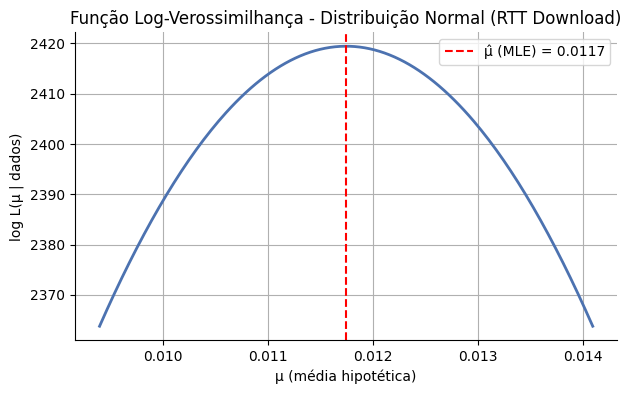

In [10]:
data = df_c1['rtt_download_sec']

mu_mle = np.mean(data)
sigma_mle = np.sqrt(np.mean((data - mu_mle)**2))
mu_values = np.linspace(mu_mle * 0.8, mu_mle * 1.2, 200)
logL = []
for mu in mu_values:
    ll = np.sum(stats.norm.logpdf(data, mu, sigma_mle))
    logL.append(ll)
logL = np.array(logL)

plt.figure(figsize=(7,4))
plt.plot(mu_values, logL, lw=2)
plt.axvline(mu_mle, color='red', linestyle='--', label=f"μ̂ (MLE) = {mu_mle:.4f}")
plt.title("Função Log-Verossimilhança - Distribuição Normal (RTT Download)")
plt.xlabel("μ (média hipotética)")
plt.ylabel("log L(μ | dados)")
plt.legend()
#savefig("rtt_down_loglikelihood.png")
plt.show()

Figura salva: ../figures/mle/rtt_download_sec_loglik_surface_normal_client13.png


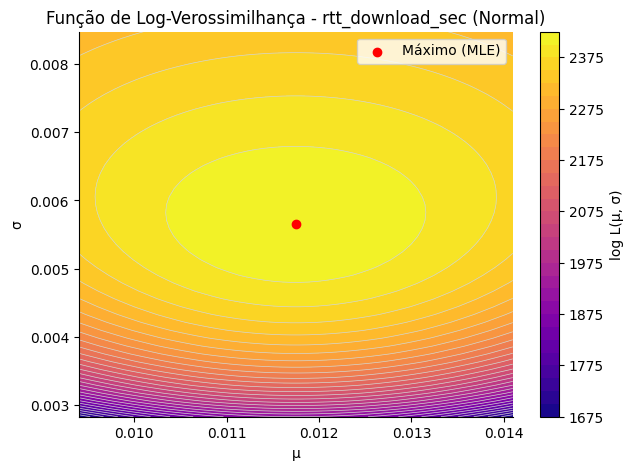

Figura salva: ../figures/mle/rtt_upload_sec_loglik_surface_normal_client13.png


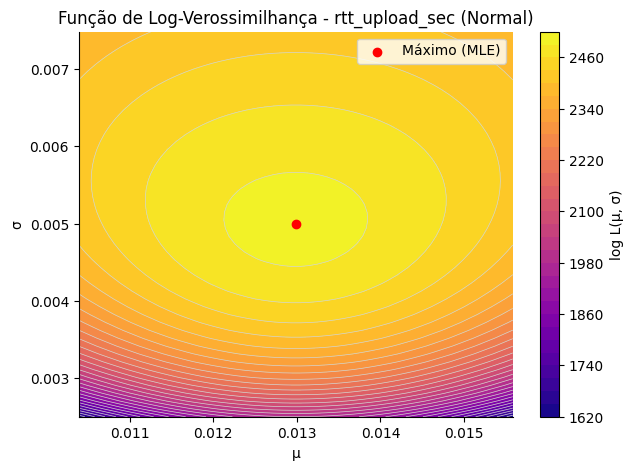

Figura salva: ../figures/mle/download_throughput_bps_loglik_surface_gamma_client13.png


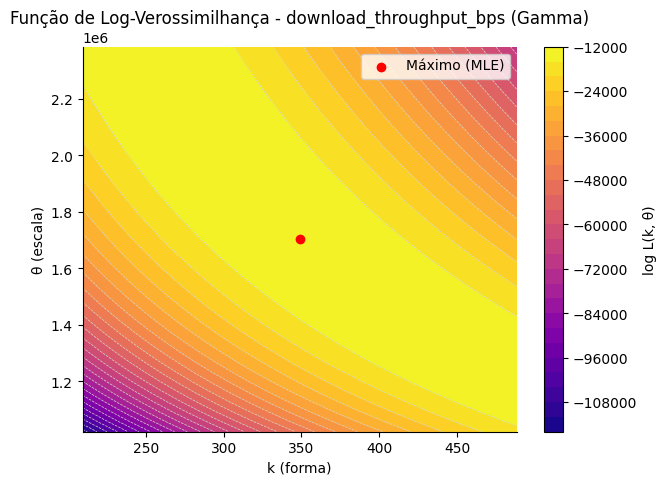

Figura salva: ../figures/mle/upload_throughput_bps_loglik_surface_gamma_client13.png


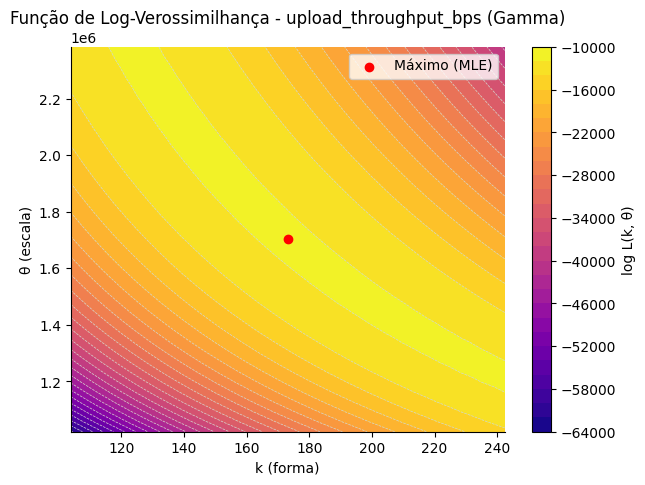

Figura salva: ../figures/mle/packet_loss_loglik_surface_beta_client13.png


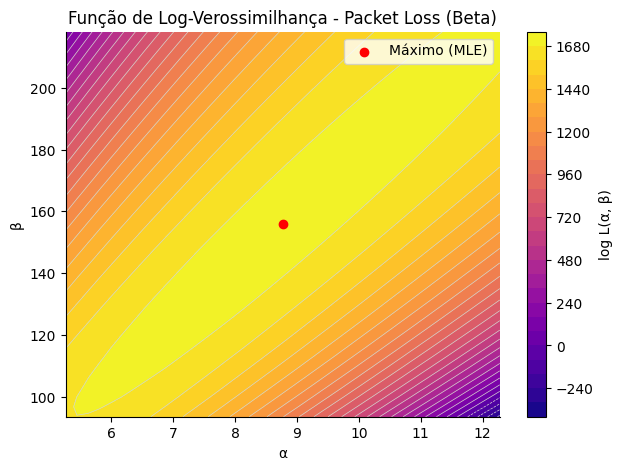

In [11]:
def log_likelihood_normal(data, mu, sigma):
    return np.sum(stats.norm.logpdf(data, mu, sigma))

def log_likelihood_gamma(data, k, theta):
    return np.sum(stats.gamma.logpdf(data, a=k, scale=theta))

def log_likelihood_beta(data, a, b):
    return np.sum(stats.beta.logpdf(data, a, b))

for var in rtt_vars:
    data = df_c1[var].dropna().values
    mu_hat, sigma_hat = np.mean(data), np.sqrt(np.mean((data - np.mean(data))**2))
    mu_range = np.linspace(mu_hat * 0.8, mu_hat * 1.2, 50)
    sigma_range = np.linspace(sigma_hat * 0.5, sigma_hat * 1.5, 50)
    MU, SIGMA = np.meshgrid(mu_range, sigma_range)
    logL = np.array([[log_likelihood_normal(data, mu, sigma) for mu in mu_range] for sigma in sigma_range])
    
    plt.figure(figsize=(7,5))
    cs = plt.contourf(MU, SIGMA, logL, 30, cmap='plasma')
    plt.contour(MU, SIGMA, logL, 30, colors='lightgray', linewidths=0.5)
    plt.grid(False)
    plt.colorbar(cs, label='log L(μ, σ)')
    plt.scatter(mu_hat, sigma_hat, color='r', label='Máximo (MLE)')
    plt.xlabel("μ")
    plt.ylabel("σ")
    plt.title(f"Função de Log-Verossimilhança - {var} (Normal)")
    plt.legend()
    filename_scatter = f"{var}_loglik_surface_normal_client13.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

for var in thr_vars:
    data = df_c1[var].dropna().values
    data = data[data > 0]
    k_hat, loc, theta_hat = stats.gamma.fit(data, floc=0)
    k_range = np.linspace(k_hat * 0.6, k_hat * 1.4, 40)
    theta_range = np.linspace(theta_hat * 0.6, theta_hat * 1.4, 40)
    K, THETA = np.meshgrid(k_range, theta_range)
    logL = np.array([[log_likelihood_gamma(data, k, t) for k in k_range] for t in theta_range])
    
    plt.figure(figsize=(7,5))
    cs = plt.contourf(K, THETA, logL, 30, cmap='plasma')
    plt.contour(K, THETA, logL, 30, colors='lightgray', linewidths=0.5)
    plt.grid(False)
    plt.colorbar(cs, label='log L(k, θ)')
    
    plt.scatter(k_hat, theta_hat, color='r', label='Máximo (MLE)')
    plt.xlabel("k (forma)")
    plt.ylabel("θ (escala)")
    plt.title(f"Função de Log-Verossimilhança - {var} (Gamma)")
    plt.legend()
    filename_scatter = f"{var}_loglik_surface_gamma_client13.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

loss_percent = df_c1['packet_loss_percent']
loss_fraction = loss_percent / 100.0
data = loss_fraction.clip(1e-6, 1 - 1e-6)
a_hat, b_hat = a_mle, b_mle
a_range = np.linspace(a_hat * 0.6, a_hat * 1.4, 40)
b_range = np.linspace(b_hat * 0.6, b_hat * 1.4, 40)
A, B = np.meshgrid(a_range, b_range)
logL = np.array([[log_likelihood_beta(data, a, b) for a in a_range] for b in b_range])

plt.figure(figsize=(7,5))
cs = plt.contourf(A, B, logL, 30, cmap='plasma') 
plt.contour(A, B, logL, 30, colors='lightgray', linewidths=0.5)
plt.grid(False) 
plt.colorbar(cs, label='log L(α, β)') 
plt.scatter(a_hat, b_hat, color='r', label='Máximo (MLE)')
plt.xlabel("α")
plt.ylabel("β")
plt.title("Função de Log-Verossimilhança - Packet Loss (Beta)")
plt.legend()
filename_scatter = "packet_loss_loglik_surface_beta_client13.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()

Server 02

In [12]:
df_c1 = df[df['server'] == 'server02']


📈 rtt_download_sec: μ̂=0.011379, σ̂=0.002638
Figura salva: ../figures/mle/rtt_download_sec_ajuste_normal_server02.png


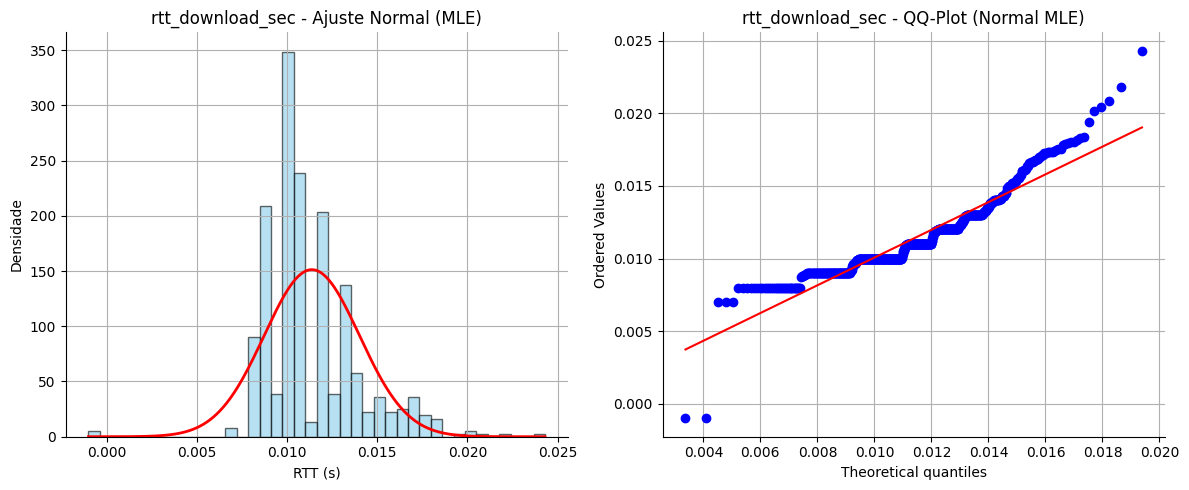


📈 rtt_upload_sec: μ̂=0.011302, σ̂=0.042392
Figura salva: ../figures/mle/rtt_upload_sec_ajuste_normal_server02.png


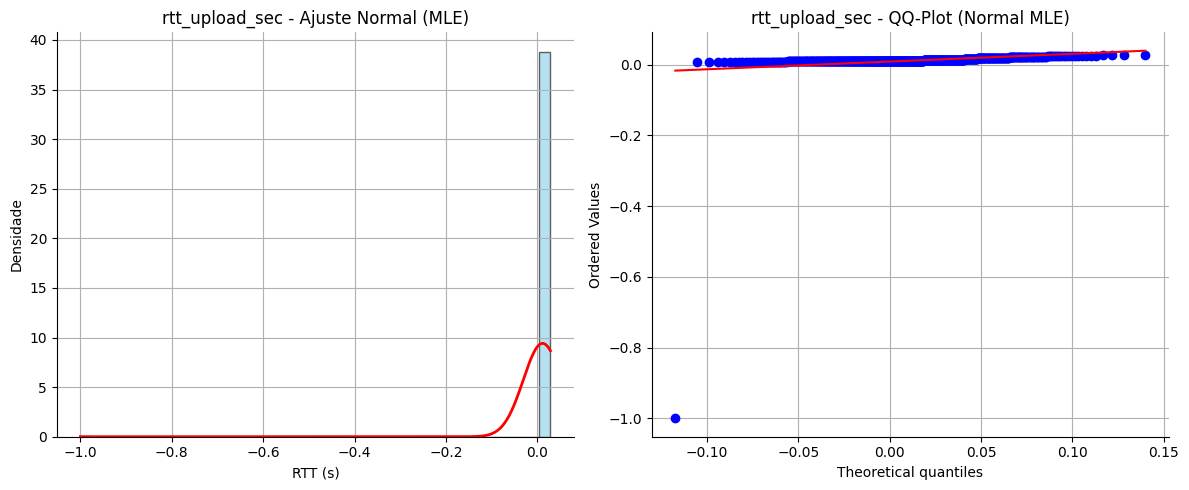

In [13]:
rtt_vars = ['rtt_download_sec', 'rtt_upload_sec']
mle_results = []

for var in rtt_vars:
    data = df_c1[var].values
    mu_mle = np.mean(df_c1[var])
    sigma_mle = np.sqrt(np.mean((df_c1[var] - mu_mle)**2))
    print(f"\n📈 {var}: μ̂={mu_mle:.6f}, σ̂={sigma_mle:.6f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(df_c1[var], bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    x = np.linspace(df_c1[var].min(), df_c1[var].max(), 400)
    axes[0].plot(x, stats.norm.pdf(x, mu_mle, sigma_mle), 'r-', lw=2)
    axes[0].set_title(f"{var} - Ajuste Normal (MLE)")
    axes[0].set_xlabel("RTT (s)")
    axes[0].set_ylabel("Densidade")

    stats.probplot(df_c1[var], dist="norm", sparams=(mu_mle, sigma_mle), plot=axes[1])
    axes[1].set_title(f"{var} - QQ-Plot (Normal MLE)")
    plt.tight_layout()
    filename_scatter = f"{var}_ajuste_normal_server02.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    mle_results.append((var, "Normal", f"μ̂={mu_mle:.4g}, σ̂={sigma_mle:.4g}", len(df_c1[var])))


⚙️ download_throughput_bps: k̂=2.569629, θ̂=247923780.977540
Figura salva: ../figures/mle/download_throughput_bps_ajuste_gamma_server02.png


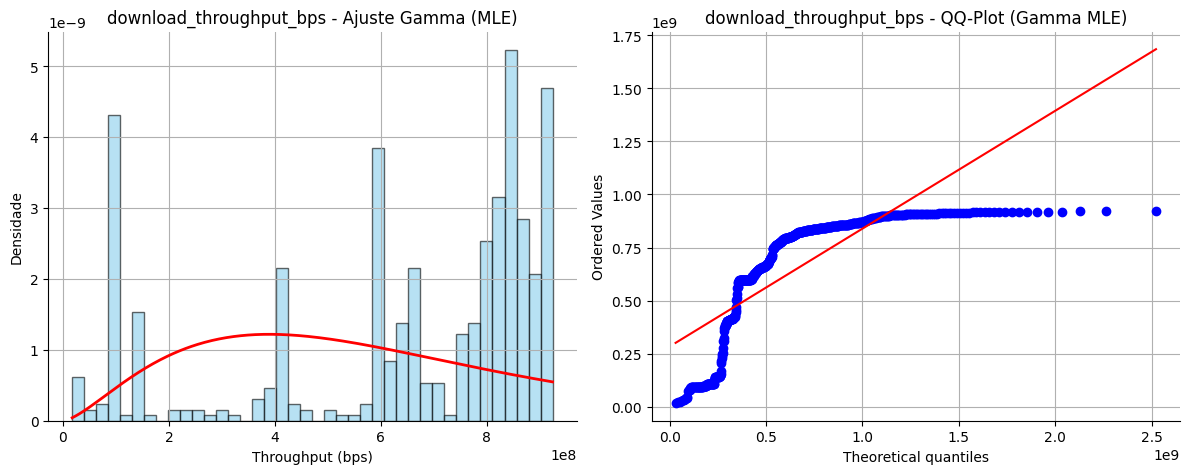


⚙️ upload_throughput_bps: k̂=1.147670, θ̂=384563662.974393
Figura salva: ../figures/mle/upload_throughput_bps_ajuste_gamma_server02.png


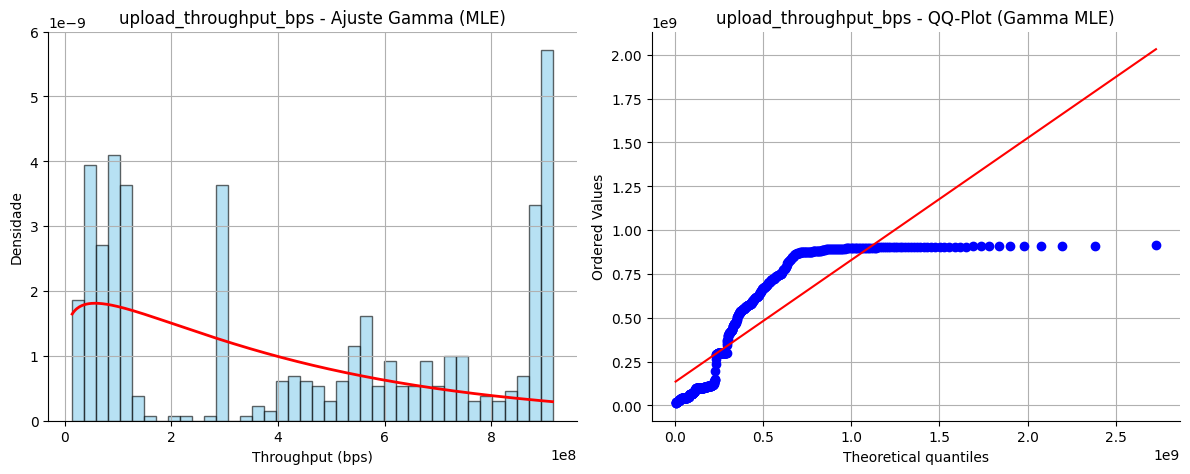

In [14]:
thr_vars = ['download_throughput_bps', 'upload_throughput_bps']

for var in thr_vars:
    data = df_c1[var]
    data = data[data > 0]
    shape, loc, scale = stats.gamma.fit(data, floc=0)
    print(f"\n⚙️ {var}: k̂={shape:.6f}, θ̂={scale:.6f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(data, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    x = np.linspace(data.min(), data.max(), 400)
    axes[0].plot(x, stats.gamma.pdf(x, a=shape, loc=0, scale=scale), 'r-', lw=2)
    axes[0].set_title(f"{var} - Ajuste Gamma (MLE)")
    axes[0].set_xlabel("Throughput (bps)")
    axes[0].set_ylabel("Densidade")

    stats.probplot(data, dist="gamma", sparams=(shape, 0, scale), plot=axes[1])
    axes[1].set_title(f"{var} - QQ-Plot (Gamma MLE)")

    plt.tight_layout()
    filename_scatter = f"{var}_ajuste_gamma_server02.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()
    
    mle_results.append((var, "Gamma", f"k̂={shape:.4g}, θ̂={scale:.4g}", len(data)))



📉 Packet Loss: α̂=0.452320, β̂=22.383163
Figura salva: ../figures/mle/packet_loss_ajuste_beta_serve02.png


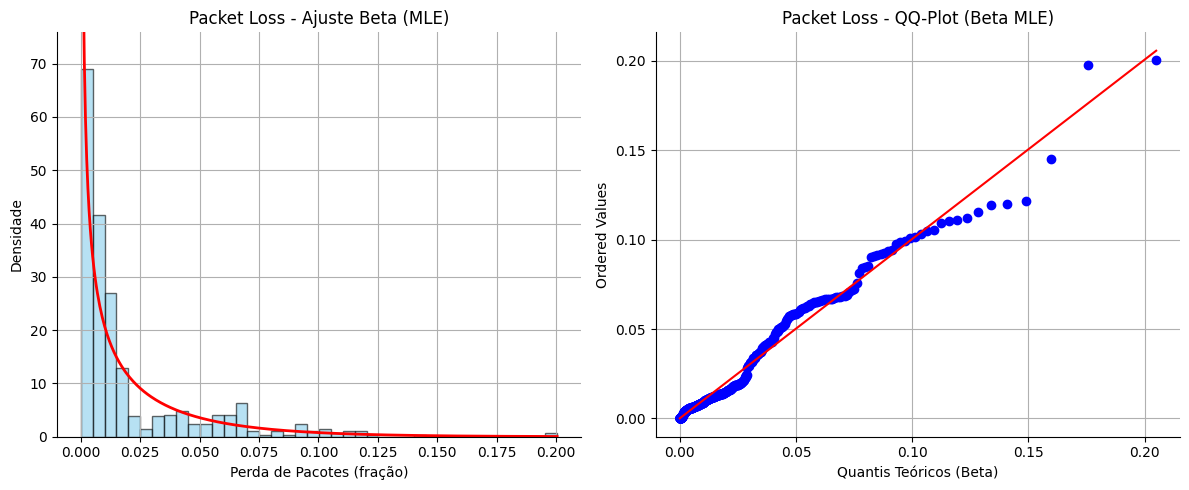

In [15]:
loss_percent = df_c1['packet_loss_percent']
loss_fraction = loss_percent / 100.0
loss_fraction_clipped = loss_fraction.clip(1e-6, 1 - 1e-6) 
a_mle, b_mle, loc, scale = stats.beta.fit(loss_fraction_clipped, floc=0, fscale=1)

print(f"\n📉 Packet Loss: α̂={a_mle:.6f}, β̂={b_mle:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
hist_output = axes[0].hist(loss_fraction_clipped, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')
x_min = loss_fraction_clipped.min()
x_max = loss_fraction_clipped.max()
x = np.linspace(x_min, x_max, 400)

axes[0].plot(x, stats.beta.pdf(x, a=a_mle, b=b_mle, loc=0, scale=1), 'r-', lw=2)
max_hist_density = hist_output[0].max()
axes[0].set_ylim(0, max_hist_density * 1.1)
axes[0].set_title("Packet Loss - Ajuste Beta (MLE)")
axes[0].set_xlabel("Perda de Pacotes (fração)")
axes[0].set_ylabel("Densidade")
stats.probplot(loss_fraction_clipped, dist="beta", sparams=(a_mle, b_mle, 0, 1), plot=axes[1])
axes[1].set_title("Packet Loss - QQ-Plot (Beta MLE)")
axes[1].set_xlabel("Quantis Teóricos (Beta)")

plt.tight_layout()
filename_scatter = "packet_loss_ajuste_beta_serve02.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()

mle_results.append(("packet_loss_percent", "Beta", f"α̂={a_mle:.4g}, β̂={b_mle:.4g}", len(loss_fraction)))

In [16]:
summary = pd.DataFrame(
    mle_results,
    columns=["Variável", "Distribuição", "Parâmetros MLE", "N"]
)

print("\nResumo das estimativas MLE:\n")
display(summary)


Resumo das estimativas MLE:



,Variável,Distribuição,Parâmetros MLE,N
0,rtt_download_sec,Normal,"μ̂=0.01138, σ̂=0.002638",576
1,rtt_upload_sec,Normal,"μ̂=0.0113, σ̂=0.04239",576
2,download_throughput_bps,Gamma,"k̂=2.57, θ̂=2.479e+08",574
3,upload_throughput_bps,Gamma,"k̂=1.148, θ̂=3.846e+08",575
4,packet_loss_percent,Beta,"α̂=0.4523, β̂=22.38",576


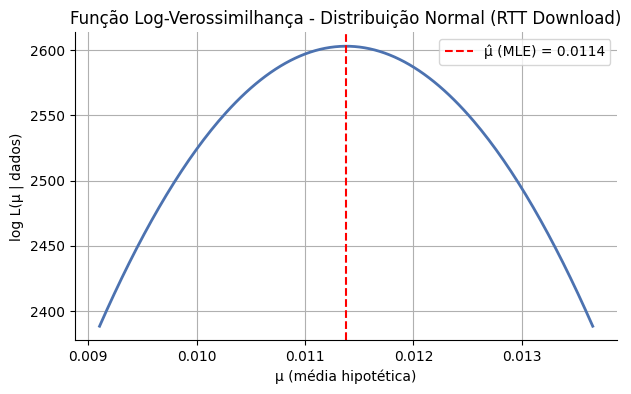

In [17]:
data = df_c1['rtt_download_sec']
mu_mle = np.mean(data)
sigma_mle = np.sqrt(np.mean((data - mu_mle)**2))
mu_values = np.linspace(mu_mle * 0.8, mu_mle * 1.2, 200)
logL = []
for mu in mu_values:
    ll = np.sum(stats.norm.logpdf(data, mu, sigma_mle))
    logL.append(ll)
logL = np.array(logL)

plt.figure(figsize=(7,4))
plt.plot(mu_values, logL, lw=2)
plt.axvline(mu_mle, color='red', linestyle='--', label=f"μ̂ (MLE) = {mu_mle:.4f}")
plt.title("Função Log-Verossimilhança - Distribuição Normal (RTT Download)")
plt.xlabel("μ (média hipotética)")
plt.ylabel("log L(μ | dados)")
plt.legend()
#savefig("rtt_down_loglikelihood.png")
plt.show()


Figura salva: ../figures/mle/rtt_download_sec_loglik_surface_normal_server02.png


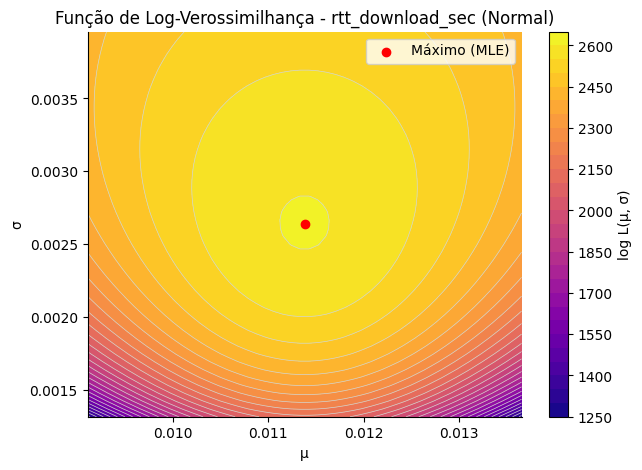

Figura salva: ../figures/mle/rtt_upload_sec_loglik_surface_normal_server02.png


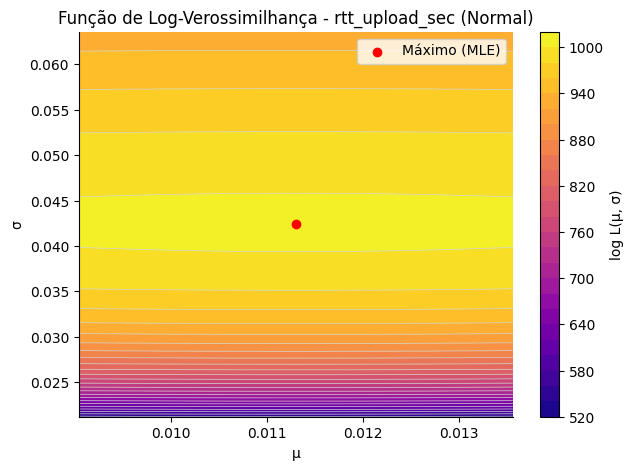

Figura salva: ../figures/mle/download_throughput_bps_loglik_surface_gamma_server02.png


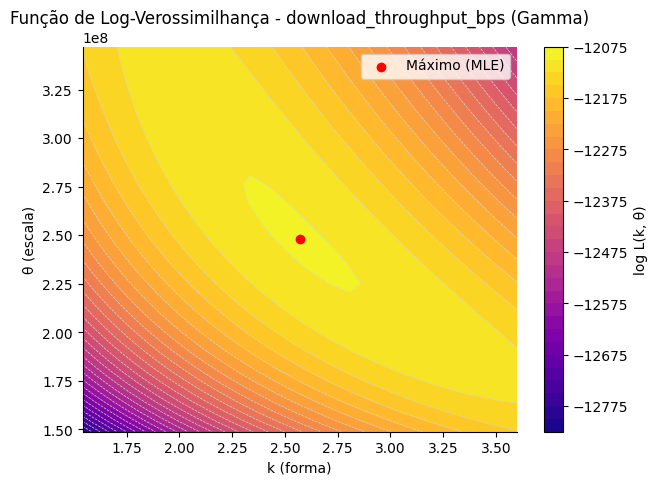

Figura salva: ../figures/mle/upload_throughput_bps_loglik_surface_gamma_server02.png


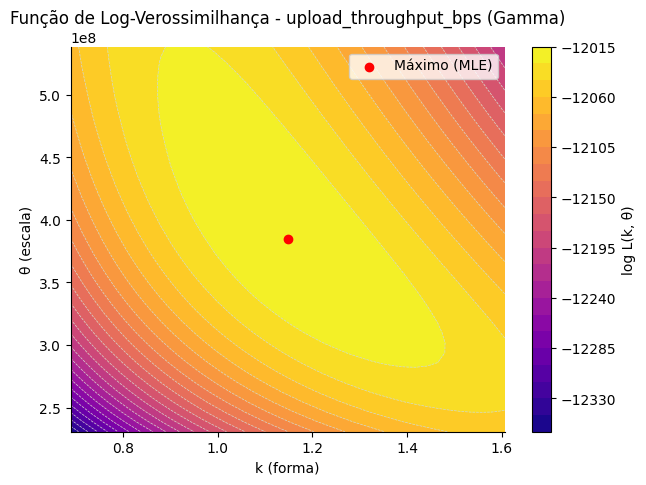

Figura salva: ../figures/mle/packet_loss_loglik_surface_beta_server02.png


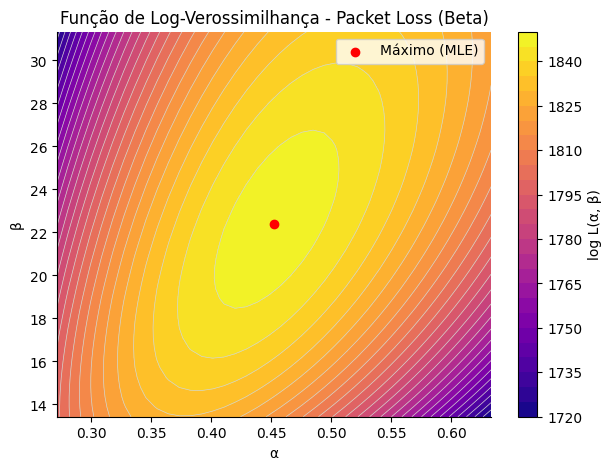

In [18]:
def log_likelihood_normal(data, mu, sigma):
    return np.sum(stats.norm.logpdf(data, mu, sigma))

def log_likelihood_gamma(data, k, theta):
    return np.sum(stats.gamma.logpdf(data, a=k, scale=theta))

def log_likelihood_beta(data, a, b):
    return np.sum(stats.beta.logpdf(data, a, b))

for var in rtt_vars:
    data = df_c1[var].dropna().values
    mu_hat, sigma_hat = np.mean(data), np.sqrt(np.mean((data - np.mean(data))**2))
    mu_range = np.linspace(mu_hat * 0.8, mu_hat * 1.2, 50)
    sigma_range = np.linspace(sigma_hat * 0.5, sigma_hat * 1.5, 50)
    MU, SIGMA = np.meshgrid(mu_range, sigma_range)
    logL = np.array([[log_likelihood_normal(data, mu, sigma) for mu in mu_range] for sigma in sigma_range])
    
    plt.figure(figsize=(7,5))
    cs = plt.contourf(MU, SIGMA, logL, 30, cmap='plasma')
    plt.contour(MU, SIGMA, logL, 30, colors='lightgray', linewidths=0.5)
    plt.grid(False)
    plt.colorbar(cs, label='log L(μ, σ)')
    plt.scatter(mu_hat, sigma_hat, color='r', label='Máximo (MLE)')
    plt.xlabel("μ")
    plt.ylabel("σ")
    plt.title(f"Função de Log-Verossimilhança - {var} (Normal)")
    plt.legend()
    filename_scatter = f"{var}_loglik_surface_normal_server02.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

for var in thr_vars:
    data = df_c1[var].dropna().values
    data = data[data > 0]
    k_hat, loc, theta_hat = stats.gamma.fit(data, floc=0)
    k_range = np.linspace(k_hat * 0.6, k_hat * 1.4, 40)
    theta_range = np.linspace(theta_hat * 0.6, theta_hat * 1.4, 40)
    K, THETA = np.meshgrid(k_range, theta_range)
    logL = np.array([[log_likelihood_gamma(data, k, t) for k in k_range] for t in theta_range])
    
    plt.figure(figsize=(7,5))
    cs = plt.contourf(K, THETA, logL, 30, cmap='plasma')
    plt.contour(K, THETA, logL, 30, colors='lightgray', linewidths=0.5)
    plt.grid(False)
    plt.colorbar(cs, label='log L(k, θ)')
    plt.scatter(k_hat, theta_hat, color='r', label='Máximo (MLE)')
    plt.xlabel("k (forma)")
    plt.ylabel("θ (escala)")
    plt.title(f"Função de Log-Verossimilhança - {var} (Gamma)")
    plt.legend()
    filename_scatter = f"{var}_loglik_surface_gamma_server02.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

loss_percent = df_c1['packet_loss_percent']
loss_fraction = loss_percent / 100.0
data = loss_fraction.clip(1e-6, 1 - 1e-6)
a_hat, b_hat = a_mle, b_mle
a_range = np.linspace(a_hat * 0.6, a_hat * 1.4, 40)
b_range = np.linspace(b_hat * 0.6, b_hat * 1.4, 40)
A, B = np.meshgrid(a_range, b_range)
logL = np.array([[log_likelihood_beta(data, a, b) for a in a_range] for b in b_range])

plt.figure(figsize=(7,5))
cs = plt.contourf(A, B, logL, 30, cmap='plasma') 
plt.contour(A, B, logL, 30, colors='lightgray', linewidths=0.5)
plt.grid(False) 
plt.colorbar(cs, label='log L(α, β)') 
plt.scatter(a_hat, b_hat, color='r', label='Máximo (MLE)')
plt.xlabel("α")
plt.ylabel("β")
plt.title("Função de Log-Verossimilhança - Packet Loss (Beta)")
plt.legend()
filename_scatter = "packet_loss_loglik_surface_beta_server02.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()